Installing Dependencies

In [28]:
# Installing dependencies
!pip install -U transformers
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
!pip install -U datasets seqeval

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-g3ly6nt8
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-g3ly6nt8
  Resolved https://github.com/facebookresearch/detectron2.git to commit 9ca668968de7f3230c67b1b572e594c0797eff30
  Preparing metadata (setup.py) ... done


In [29]:
!sudo apt install tesseract-ocr
!sudo apt install libtesseract-dev
!pip install pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libtesseract-dev is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [30]:
# More dependencies and dataset
import pandas as pd
import torch, torchvision
from torch.utils.data import DataLoader
from datasets import load_dataset
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
import cv2

In [31]:
# Load FUNSD dataset
datasets = load_dataset("nielsr/funsd")

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1461: FutureWarning: The repository for nielsr/funsd contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/nielsr/funsd
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [32]:
#Display Features and Labels
features = list(datasets['train'].features.keys())
labels = datasets['train'].features['ner_tags'].feature.names
id2label = {v: k for v, k in enumerate(labels)}

# Convert labels and id2label dictionary to DataFrame for better visualization
labels_df = pd.DataFrame(labels, columns=['Labels'])
id2label_df = pd.DataFrame(list(id2label.items()), columns=['ID', 'Label'])

# Displaying the DataFrames
print("Features:")
print(pd.DataFrame(features, columns=['Feature Names']))

print("\nLabels:")
print(labels_df)

print("\nID to Label Mapping:")
print(id2label_df)

Features:
  Feature Names
0            id
1         words
2        bboxes
3      ner_tags
4    image_path

Labels:
       Labels
0           O
1    B-HEADER
2    I-HEADER
3  B-QUESTION
4  I-QUESTION
5    B-ANSWER
6    I-ANSWER

ID to Label Mapping:
   ID       Label
0   0           O
1   1    B-HEADER
2   2    I-HEADER
3   3  B-QUESTION
4   4  I-QUESTION
5   5    B-ANSWER
6   6    I-ANSWER


**Pre Processing**

In [33]:
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D

# Define custom features for a dataset that includes both text and image processing components.
features = Features({
    'input_ids': Sequence(feature=Value(dtype='int64')),  # Sequence of integers representing token ids in the text.
    'attention_mask': Sequence(Value(dtype='int64')),  # Sequence of integers (0 or 1) to indicate which tokens should be attended to by the model.
    'token_type_ids': Sequence(Value(dtype='int64')),  # Sequence of integers distinguishing segments of tokens.
    'bbox': Array2D(dtype="int64", shape=(512, 4)),  # 2D array of bounding box coordinates for document layout analysis.
    'labels': Sequence(ClassLabel(names=labels)),  # Sequence of class labels for each token or image segment.
    'image': Array3D(dtype="int64", shape=(3, 224, 224)),  # 3D array representing an image in the format of channels (3 for RGB), height, and width.
})


In [34]:
from PIL import Image, ImageDraw, ImageFont
from transformers import LayoutLMv2Processor

# Initialize the LayoutLMv2 processor from a pre-trained model for handling multimodal (text and image) inputs.
processor = LayoutLMv2Processor.from_pretrained("microsoft/layoutlmv2-base-uncased", revision="no_ocr")

def preprocess_data(examples):
    """
    Preprocess the data by converting images to RGB, encoding text and labels, and adjusting format for model input.

    Args:
    examples (dict): A dictionary containing image paths, words, bounding boxes, and NER tags.

    Returns:
    dict: A dictionary with processed features suitable for input into the LayoutLMv2 model.
    """
    # Convert images from file paths to RGB images
    images = [Image.open(path).convert("RGB") for path in examples['image_path']]
    words = examples['words']
    boxes = examples['bboxes']
    word_labels = examples['ner_tags']

    # Encode the inputs using the LayoutLMv2 processor
    encoded_inputs = processor(images, words, boxes=boxes, word_labels=word_labels,
                               padding="max_length", truncation=True)
    return encoded_inputs

# Map the preprocessing function to the training and testing datasets, remove original columns, and define new features schema.
train_dataset = datasets['train'].map(preprocess_data, batched=True, remove_columns=datasets['train'].column_names, features=features)
test_dataset = datasets['test'].map(preprocess_data, batched=True, remove_columns=datasets['test'].column_names, features=features)


In [35]:
# Determine if CUDA is available in the environment, and set the device accordingly.
device_name = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Torch Version: {torch.__version__}, is_CUDA: {torch.cuda.is_available()}, Device: {device_name}')

# Configure datasets to be loaded into PyTorch tensors, automatically moved to the specified device.
train_dataset.set_format(type="torch", device=device_name)
test_dataset.set_format(type="torch", device=device_name)

# Create DataLoader for the training dataset with batching, shuffling, and device assignment.
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# Create DataLoader for the testing dataset with batching and device assignment, without shuffling.
test_dataloader = DataLoader(test_dataset, batch_size=2)


Torch Version: 2.2.1+cu121, is_CUDA: True, Device: cuda


In [36]:
# Retrieve the first batch from the training DataLoader.
batch = next(iter(train_dataloader))

# Iterate through the dictionary of batch components and print the key (name of the component) and its tensor shape.
for k, v in batch.items():
    print(k, v.shape)


input_ids torch.Size([4, 512])
attention_mask torch.Size([4, 512])
token_type_ids torch.Size([4, 512])
bbox torch.Size([4, 512, 4])
labels torch.Size([4, 512])
image torch.Size([4, 3, 224, 224])


**Creating Model**

In [37]:
from transformers import LayoutLMv2ForTokenClassification, AdamW
import torch

# Load a pre-trained LayoutLMv2 model for token classification from Hugging Face's model hub.
model = LayoutLMv2ForTokenClassification.from_pretrained(
    'microsoft/layoutlmv2-base-uncased', num_labels=len(labels)
)

# Move the model to the appropriate device (GPU or CPU).
model.to(torch.device(device_name))


Some weights of LayoutLMv2ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv2-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LayoutLMv2ForTokenClassification(
  (layoutlmv2): LayoutLMv2Model(
    (embeddings): LayoutLMv2Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (x_position_embeddings): Embedding(1024, 128)
      (y_position_embeddings): Embedding(1024, 128)
      (h_position_embeddings): Embedding(1024, 128)
      (w_position_embeddings): Embedding(1024, 128)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (visual): LayoutLMv2VisualBackbone(
      (backbone): FPN(
        (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
        (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
        (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  

In [38]:
from transformers import LayoutLMv2ForTokenClassification, LayoutLMv2Config

labels = datasets['train'].features['ner_tags'].feature.names
id2label = {i: label for i, label in enumerate(labels)}
label2id = {label: i for i, label in enumerate(labels)}
# Load the pre-trained model with the specific label configuration
config = LayoutLMv2Config.from_pretrained(
    "microsoft/layoutlmv2-base-uncased",
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id
)
model = LayoutLMv2ForTokenClassification.from_pretrained(
    "microsoft/layoutlmv2-base-uncased",
    config=config
)


Some weights of LayoutLMv2ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv2-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**Inference from pre-trained model**

In [39]:
import pytesseract
# Step 1: Load a test image
example = datasets["test"][4]
image = Image.open(example['image_path']).convert("RGB")
# Obtain the original image dimensions.
width, height = image.size

# Use pytesseract to extract text and bounding boxes
ocr_result = pytesseract.image_to_data(image, output_type=pytesseract.Output.DICT)

# Filter out empty text and prepare inputs
words = [ocr_result['text'][i] for i in range(len(ocr_result['text'])) if ocr_result['text'][i].strip() != '']
boxes = [(ocr_result['left'][i], ocr_result['top'][i], ocr_result['left'][i] + ocr_result['width'][i], ocr_result['top'][i] + ocr_result['height'][i]) for i in range(len(ocr_result['text'])) if ocr_result['text'][i].strip() != '']

# Prepare the processor inputs
inputs = processor(image, words, boxes=boxes, return_tensors="pt")

# Move tensors to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inputs = {k: v.to(device) for k, v in inputs.items()}
model.to(device)

# Set the model in evaluation mode and perform inference
model.eval()
with torch.no_grad():
    outputs = model(**inputs)

# Post-process the outputs
predictions = outputs.logits.argmax(-1).squeeze().tolist()
labels = [model.config.id2label[pred] for pred in predictions]

# Display the results
for word, label in zip(words, labels):
    print(f"{word}: {label}")


KA,: I-ANSWER
Sparrow: B-ANSWER
FROM:: I-HEADER
D.: I-HEADER
J.: O
Landro: O
May: B-ANSWER
4[: B-ANSWER
aus: B-ANSWER
4|: B-ANSWER
JUN: O
23): O
SEP: B-ANSWER
45: B-HEADER
‘SUBJECT:: B-ANSWER
OLD: B-ANSWER
GOLD: B-ANSWER
MENTHOL: I-QUESTION
LIGHTS: B-ANSWER
&: I-HEADER
ULTRA: I-QUESTION
LIGHTS: B-ANSWER
10'S: I-QUESTION
-: I-ANSWER
PROGRESS: I-HEADER
REPORT: O
REGION:: B-ANSWER
(ONLY: B-ANSWER
IF: B-HEADER
PARTIAL: B-QUESTION
REGION: B-QUESTION
CONTINUE: I-ANSWER
WITH: I-ANSWER
DIVISION(S): I-ANSWER
SCOPE): I-ANSWER
DIVISION:: I-QUESTION
DIVISION: I-ANSWER
NAME:: I-ANSWER
Milw.: I-ANSWER
South_: B-ANSWER
DIVISION: B-ANSWER
NAME:: I-HEADER
#REP: O
DIVISION: O
NAME:: I-HEADER
Milw.: B-QUESTION
North: B-QUESTION
_: I-HEADER
DIVISION: B-ANSWER
NAME:: B-ANSWER
#REP: I-QUESTION
z: B-QUESTION
DIVISION: B-QUESTION
NAME:: O
DIVISION: I-HEADER
NAME:: I-HEADER
#REPS: B-ANSWER
DIRECT: O
ACCOUNTS: B-ANSWER
AND: I-HEADER
CHAINS: O
HEADQUARTERED: B-ANSWER
WITHIN: I-HEADER
THE: I-HEADER
REGION: B-HEAD

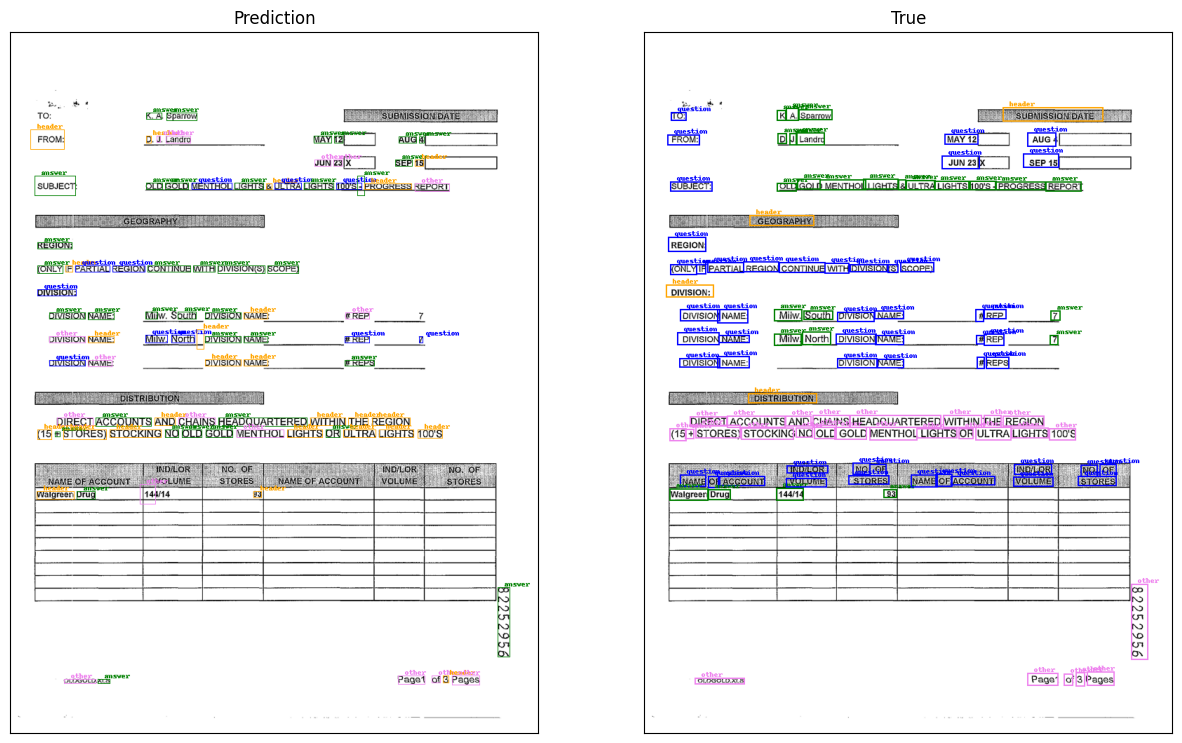

In [40]:
# Initialize ImageDraw to start annotation
draw = ImageDraw.Draw(image)

font = ImageFont.load_default()

def pred2label(label):
    """
    Extract the entity type from a label, returning 'other' if not specified.
    Args:
    label (str): The label in IOB format (e.g., 'B-question').

    Returns:
    str: The label without the IOB prefix or 'other' if no specific label is present.
    """
    return 'other' if not label[2:] else label[2:]


def unnormalize_box(bbox, width, height):
    """
    Convert normalized bounding box coordinates back to pixel coordinates.

    Args:
    bbox (list of float): Normalized coordinates [xmin, ymin, xmax, ymax].
    width (int): The width of the original image.
    height (int): The height of the original image.

    Returns:
    list of float: The bounding box coordinates scaled to the original image size.
    """
    return [
        width * (bbox[0] / 1000),  # Scale xmin to image width
        height * (bbox[1] / 1000), # Scale ymin to image height
        width * (bbox[2] / 1000),  # Scale xmax to image width
        height * (bbox[3] / 1000), # Scale ymax to image height
    ]



# Define color mappings for different entity types
label2color = {'question': 'blue', 'answer': 'green', 'header': 'orange', 'other': 'violet'}

# Initialize drawing on the original image
draw = ImageDraw.Draw(image)
font = ImageFont.load_default()

# Loop to draw the boxes and labels
for prediction, box in zip(labels, boxes):
    predicted_label = pred2label(prediction).lower()  # Get the label name from the model config
    # box = unnormalize_box(box, width, height)
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)


# Save the image with predictions for later comparison or display
pred_image = image

# # Load the original image again for comparison with ground truth annotations
true_image = Image.open(example['image_path']).convert("RGB")
draw = ImageDraw.Draw(true_image)

# Draw ground truth labels and bounding boxes
for word, box, label in zip(example['words'], example['bboxes'], example['ner_tags']):
    actual_label = pred2label(id2label[label]).lower()
    box = unnormalize_box(box, width, height)
    draw.rectangle(box, outline=label2color[actual_label], width=2)
    draw.text((box[0] + 10, box[1] - 10), actual_label, fill=label2color[actual_label], font=font)

# Save or display the comparison image
true_image.show()

# Create a figure with two subplots arranged horizontally, each subplot will display an image.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,10))

# Display the image with model predictions in the first subplot.
axes[0].imshow(pred_image)
axes[0].set_title('Prediction')  # Title to indicate this is the predicted output.

# Display the image with true annotations in the second subplot.
axes[1].imshow(true_image)
axes[1].set_title('True')  # Title to indicate this is the ground truth.

# Remove x and y axis ticks for both subplots to focus on the images themselves.
axes[0].set_xticks([]); axes[0].set_yticks([])
axes[1].set_xticks([]); axes[1].set_yticks([])

# Display the figure with the images.
plt.show()

**Fine-Tuning Model**

In [41]:
model.to(torch.device(device_name))
model.train()  #put the model in training mode
optimizer = AdamW(model.parameters(), lr=5e-5)

num_train_epochs = 10
t_total = len(train_dataloader) * num_train_epochs # total number of training steps

for global_step, epoch in enumerate(range(num_train_epochs)):
    if (global_step+1)%100 == 0:
        print(f"Epoch: {epoch} Loss after {global_step} steps: {loss.item()}")
    for batch in tqdm(train_dataloader):
        optimizer.zero_grad() # zero the parameter gradients
        outputs = model(**batch)  # forward propagation
        loss = outputs.loss
        loss.backward()  # backward propagation
        optimizer.step()  # optimizaiton

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 38/38 [00:25<00:00,  1.52it/s]


**Evaluating Model**

In [42]:
from datasets import load_metric
from seqeval.metrics import classification_report
from seqeval.scheme import IOB2

# Load the 'seqeval' metric for evaluating sequence labeling
metric = load_metric("seqeval")

# Lists to accumulate predictions and labels from the evaluation loop
true_predictions_total = []
true_labels_total = []

# Switch model to evaluation mode, which turns off dropout layers and batch normalization during inference
model.eval()

# Loop through batches in the test dataset
for batch in tqdm(test_dataloader, desc="Evaluating"):
    # Torch's no_grad context manager to disable gradient computation, saving memory and speeding up inference
    with torch.no_grad():
        # Move all parts of the input batch to the specified device (GPU/CPU)
        input_ids = batch['input_ids'].to(torch.device(device_name))
        bbox = batch['bbox'].to(torch.device(device_name))
        image = batch['image'].to(torch.device(device_name))
        attention_mask = batch['attention_mask'].to(torch.device(device_name))
        token_type_ids = batch['token_type_ids'].to(torch.device(device_name))
        labels = batch['labels'].to(torch.device(device_name))

        # Forward pass: compute the outputs of the model
        outputs = model(input_ids=input_ids, bbox=bbox, image=image, attention_mask=attention_mask,
                        token_type_ids=token_type_ids, labels=labels)

        # Get the highest probability predictions from logits
        predictions = outputs.logits.argmax(dim=2)

        # Process the predictions and the labels to exclude those tokens with a padding label (-100)
        true_predictions = [
            [id2label[p.item()] for (p, l) in zip(prediction, label) if l != -100]
            for prediction, label in zip(predictions, labels)
        ]
        true_labels = [
            [id2label[l.item()] for (p, l) in zip(prediction, label) if l != -100]
            for prediction, label in zip(predictions, labels)
        ]

        # Extend the collected lists of predictions and labels for later evaluation
        true_predictions_total.extend(true_predictions)
        true_labels_total.extend(true_labels)

# Compute the evaluation metrics using seqeval
final_score = metric.compute(predictions=true_predictions_total, references=true_labels_total)


<ipython-input-42-3ef161e73312>:6: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


Evaluating: 100%|██████████| 25/25 [00:03<00:00,  7.97it/s]


In [43]:
# Convert the final_score dictionary to a pandas DataFrame for better readability and display.
df_final_score = pd.DataFrame(final_score)

# Display the DataFrame to view the evaluation metrics
df_final_score

,ANSWER,HEADER,QUESTION,overall_precision,overall_recall,overall_f1,overall_accuracy
precision,0.702236,0.584158,0.813636,0.75286,0.825389,0.787458,0.7887
recall,0.854141,0.495798,0.840376,0.75286,0.825389,0.787458,0.7887
f1,0.770775,0.536364,0.826790,0.75286,0.825389,0.787458,0.7887
number,809.000000,119.000000,1065.000000,0.75286,0.825389,0.787458,0.7887


In [44]:
# Print the classification report using the true and predicted labels collected during model evaluation.
print(classification_report(true_labels_total, true_predictions_total))


              precision    recall  f1-score   support

      ANSWER       0.70      0.85      0.77       809
      HEADER       0.58      0.50      0.54       119
    QUESTION       0.81      0.84      0.83      1065

   micro avg       0.75      0.83      0.79      1993
   macro avg       0.70      0.73      0.71      1993
weighted avg       0.75      0.83      0.79      1993



**Inference using Fine-Tuned Model**

In [45]:
# Load a test sample from the dataset
example = datasets["test"][4]
image = Image.open(example['image_path']).convert("RGB")

# Preprocess this sample using the LayoutLMv2 processor
# This step encodes the text, bounding boxes, and image into model-ready tensors,
# applies necessary padding and truncation, and prepares labels for loss computation.
encoded_inputs = processor(image, example['words'], boxes=example['bboxes'], word_labels=example['ner_tags'],
                           padding="max_length", truncation=True, return_tensors="pt")

# Separate the labels and convert the rest of the batch to the appropriate device
labels = encoded_inputs.pop('labels').squeeze().tolist()
for k, v in encoded_inputs.items():
    encoded_inputs[k] = v.to(torch.device(device_name))

# Perform a forward pass through the model to get logits
# The model is assumed to be already in evaluation mode with `model.eval()`
outputs = model(**encoded_inputs)
predictions = outputs.logits.argmax(dim=-1).squeeze().tolist()

#  `predicted_labels` and `labels` to compare model predictions with true labels


In [46]:
def unnormalize_box(bbox, width, height):
    """
    Convert normalized bounding box coordinates back to pixel coordinates.

    Args:
    bbox (list of float): Normalized coordinates [xmin, ymin, xmax, ymax].
    width (int): The width of the original image.
    height (int): The height of the original image.

    Returns:
    list of float: The bounding box coordinates scaled to the original image size.
    """
    return [
        width * (bbox[0] / 1000),  # Scale xmin to image width
        height * (bbox[1] / 1000), # Scale ymin to image height
        width * (bbox[2] / 1000),  # Scale xmax to image width
        height * (bbox[3] / 1000), # Scale ymax to image height
    ]

# Extract the predicted class indices from the logits and convert to list.
predictions = outputs.logits.argmax(-1).squeeze().tolist()
# Retrieve token bounding boxes from encoded inputs and convert to list.
token_boxes = encoded_inputs['bbox'].squeeze().tolist()

# Obtain the original image dimensions.
width, height = image.size

# Filter out predictions and labels corresponding to non-ignored tokens (-100),
# and convert prediction indices to their respective labels.
true_predictions = [id2label[prediction] for prediction, label in zip(predictions, labels) if label != -100]
true_labels = [id2label[label] for prediction, label in zip(predictions, labels) if label != -100]

# Unnormalize the bounding boxes for the true predictions using the original image dimensions.
true_boxes = [unnormalize_box(box, width, height) for box, label in zip(token_boxes, labels) if label != -100]

In [47]:
from PIL import Image, ImageDraw, ImageFont

def pred2label(label):
    """
    Extract the entity type from a label, returning 'other' if not specified.
    Args:
    label (str): The label in IOB format (e.g., 'B-question').

    Returns:
    str: The label without the IOB prefix or 'other' if no specific label is present.
    """
    return 'other' if not label[2:] else label[2:]

# Define color mappings for different entity types
label2color = {'question': 'blue', 'answer': 'green', 'header': 'orange', 'other': 'violet'}

# Initialize drawing on the original image
draw = ImageDraw.Draw(image)
font = ImageFont.load_default()

# Draw predicted labels and bounding boxes on the image
for prediction, box in zip(true_predictions, true_boxes):
    predicted_label = pred2label(prediction).lower()
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)

# Save the image with predictions for later comparison or display
pred_image = image

# Load the original image again for comparison with ground truth annotations
true_image = Image.open(example['image_path']).convert("RGB")
draw = ImageDraw.Draw(true_image)

# Draw ground truth labels and bounding boxes
for word, box, label in zip(example['words'], example['bboxes'], example['ner_tags']):
    actual_label = pred2label(id2label[label]).lower()
    box = unnormalize_box(box, width, height)
    draw.rectangle(box, outline=label2color[actual_label], width=2)
    draw.text((box[0] + 10, box[1] - 10), actual_label, fill=label2color[actual_label], font=font)

# Save or display the comparison image
true_image.show()

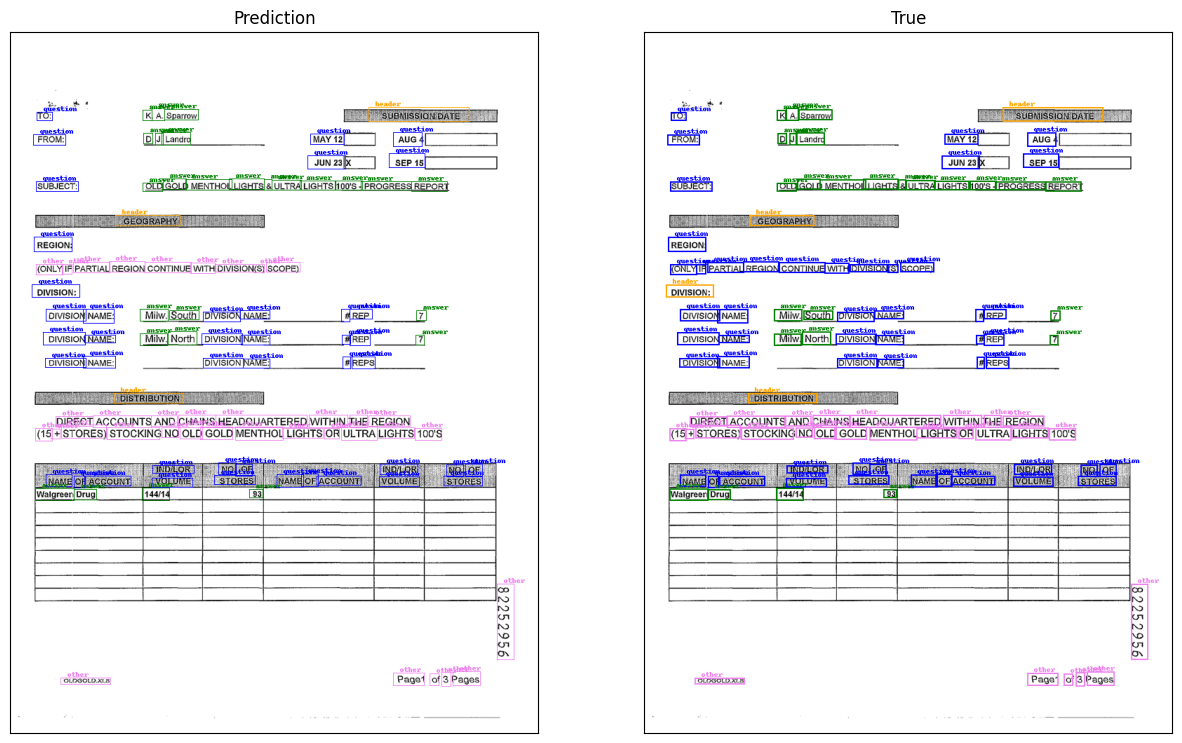

In [48]:
# Create a figure with two subplots arranged horizontally, each subplot will display an image.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,10))

# Display the image with model predictions in the first subplot.
axes[0].imshow(pred_image)
axes[0].set_title('Prediction')  # Title to indicate this is the predicted output.

# Display the image with true annotations in the second subplot.
axes[1].imshow(true_image)
axes[1].set_title('True')  # Title to indicate this is the ground truth.

# Remove x and y axis ticks for both subplots to focus on the images themselves.
axes[0].set_xticks([]); axes[0].set_yticks([])
axes[1].set_xticks([]); axes[1].set_yticks([])

# Display the figure with the images.
plt.show()

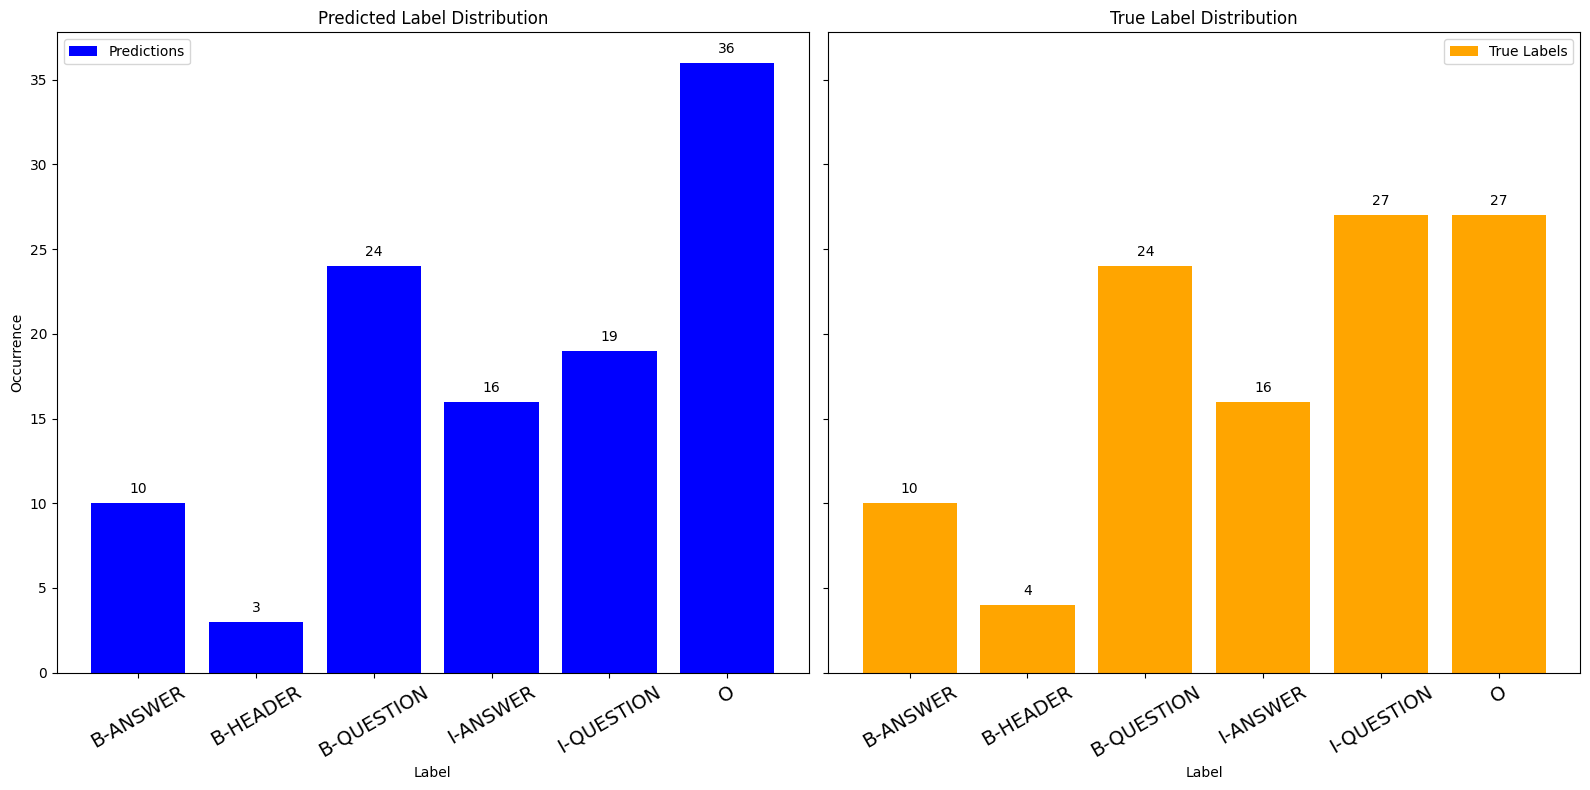

In [49]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Count the occurrences of each label in the predictions and true labels.
prediction_counts = Counter(true_predictions)
label_counts = Counter(true_labels)

# Get the list of all label names sorted alphabetically.
all_labels = sorted(set(true_predictions + true_labels))

# Create the counts for each label, ensuring all labels appear on both histograms.
prediction_distribution = [prediction_counts.get(label, 0) for label in all_labels]
label_distribution = [label_counts.get(label, 0) for label in all_labels]

# Create a figure with subplots.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8), sharey=True)

# Plot histograms for predictions.
axes[0].bar(all_labels, prediction_distribution, color='blue', label='Predictions')
axes[0].set_title('Predicted Label Distribution')
axes[0].set_ylabel('Occurrence')
axes[0].set_xlabel('Label')
axes[0].tick_params(axis='x', labelrotation=30, labelsize=14)
axes[0].legend()

# Plot histograms for true labels.
axes[1].bar(all_labels, label_distribution, color='orange', label='True Labels')
axes[1].set_title('True Label Distribution')
axes[1].set_xlabel('Label')
axes[1].tick_params(axis='x', labelrotation=30, labelsize=14)
axes[1].legend()

# Add data labels on top of each bar to display the count.
for ax in axes:
    for bar in ax.patches:
        height = bar.get_height()
        ax.annotate(f'{int(height)}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5),  # 5 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()